In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(split_xy=True):
    heart = pd.read_csv("heart.csv", header=None)
    heart.loc[heart[13] < 1, 13] = 0
    heart = heart.to_numpy()
    
    #heart = pd.read_csv("heart.csv", header=None).to_numpy()
    if split_xy:
        return heart[:,:-1], heart[:,-1]
    else:
        return heart

X, y = load_data()

In [2]:
X

array([[70.,  1.,  4., ...,  2.,  3.,  3.],
       [67.,  0.,  3., ...,  2.,  0.,  7.],
       [57.,  1.,  2., ...,  1.,  0.,  7.],
       ...,
       [56.,  0.,  2., ...,  2.,  0.,  3.],
       [57.,  1.,  4., ...,  2.,  0.,  6.],
       [67.,  1.,  4., ...,  2.,  3.,  3.]])

In [3]:
X.shape

(270, 13)

In [4]:
y[:10]

array([0., 1., 0., 1., 1., 1., 0., 0., 0., 0.])

In [5]:
y.shape

(270,)

In [6]:
np.unique(y, return_counts=True)

(array([0., 1.]), array([120, 150]))

In [7]:
print("4 out of 9 patients has a heart disease, 5 out 9 don't")

4 out of 9 patients has a heart disease, 5 out 9 don't


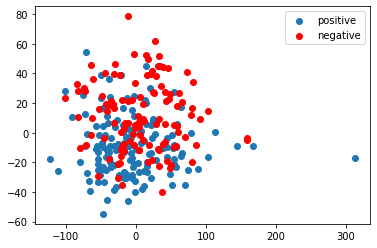

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(X)
plt.scatter(pca.T[0][y == 1], pca.T[1][y == 1], label="positive")
plt.scatter(pca.T[0][y == 0], pca.T[1][y == 0], color="red", label="negative")
plt.legend()

# With packages

In [9]:
import torch
from torch import nn, optim
from torch.nn.modules import Module
from torch.utils.data import Dataset, DataLoader

/Users/danish/Documents/linalg-opti/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler    


X,y = load_data(split_xy=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([ 90, 112]))

In [12]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
   
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [13]:
train_dataloader = DataLoader(
    train_data,
    batch_size=1,
    shuffle=False
)

train_dataloader

In [14]:
test_dataloader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False
)

train_dataloader

In [15]:
torch.tensor(X, dtype=torch.float).shape

torch.Size([270, 13])

In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, layers_data: list):
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_size = input_size
        for size, activation in layers_data:
            self.layers.append(nn.Linear(input_size, size))
            input_size = size
            if activation is not None:
                assert isinstance(activation, Module), \
                    "Each tuples should contain a size (int) and a torch.nn.modules.Module."
                self.layers.append(activation)        

    def forward(self, input_data):
        for layer in self.layers:
            input_data = layer(input_data)
        return input_data

layer1, layer2, layer3 = 10, 5, 2
output_layer = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlp = MLP(X.shape[1], [
    (layer1, None),
    (layer2, None),
    (layer3, nn.ReLU()),
    (output_layer, nn.Sigmoid())
])

mlp.to(device)

print(mlp)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=13, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [17]:
mlp(torch.tensor(X, dtype=torch.float))[:10]

tensor([[0.6331],
        [0.6931],
        [0.6009],
        [0.6071],
        [0.6292],
        [0.5970],
        [0.6022],
        [0.6085],
        [0.6111],
        [0.6404]], grad_fn=<SliceBackward0>)

In [18]:
torch.round(mlp(torch.tensor(X, dtype=torch.float)))[:10]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SliceBackward0>)

In [19]:
learning_rate = 0.001
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    
    return torch.round(acc * 100)

In [20]:
criterion = nn.BCELoss()
epochs = 1000

mlp.train()
for epoch in range(1,epochs+1):  # loop over the dataset multiple times
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = mlp(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(-1))
        acc = binary_acc(outputs, y_batch.unsqueeze(-1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    # print statistics
    if epoch % 100 == 0:
        print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} | Acc: {epoch_acc/len(train_dataloader):.5f}')
        
print('Finished Training')

Epoch 100: | Loss: 0.17991 | Acc: 91.08911
Epoch 200: | Loss: 0.16574 | Acc: 90.59406
Epoch 300: | Loss: 0.16896 | Acc: 91.08911
Epoch 400: | Loss: 0.15508 | Acc: 90.09901
Epoch 500: | Loss: 0.16328 | Acc: 89.60396
Epoch 600: | Loss: 0.16320 | Acc: 89.60396
Epoch 700: | Loss: 0.15459 | Acc: 90.59406
Epoch 800: | Loss: 0.17126 | Acc: 90.09901
Epoch 900: | Loss: 0.18202 | Acc: 87.12871
Epoch 1000: | Loss: 0.16930 | Acc: 88.61386
Finished Training


In [21]:
y_pred_list = []
mlp.eval()
with torch.no_grad():
    for X_batch in test_dataloader:
        X_batch = X_batch.to(device)
        y_test_pred = mlp(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = np.array([a.squeeze().tolist() for a in y_pred_list])

In [22]:
y_pred_list

array([1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.])

In [23]:
y_test

array([1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.])

In [24]:
correct_results_sum = (y_pred_list == y_test).sum()
acc = correct_results_sum/y_test.shape[0]
acc*100

72.05882352941177

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_list)


array([[17, 13],
       [ 6, 32]])